# Simulation #1
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the Perron-Frobenius operator.

In [39]:
using Plots

In [40]:
include("functions.jl");

In [41]:
pyplot();

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [42]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [43]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### An initial density
We will define an initial uniform density $f_0 (x, y)$ on this state space.

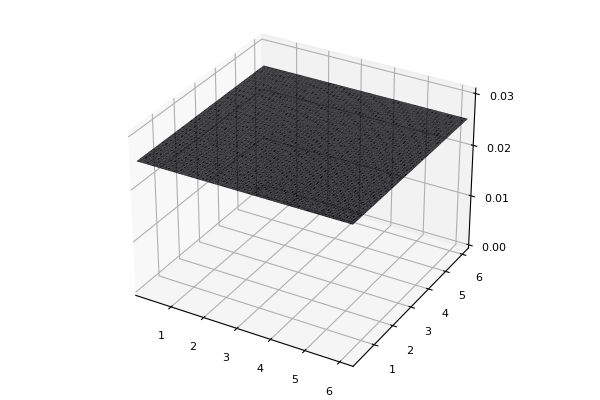

In [44]:
f0s = [f(grid[n,:], range) for n in 1:n_gridpoints];
surface(grid[:,1], grid[:,2], f0s, legend=false, markersize=1)
zlims!(0, 1.2 * (1/(range^2)))

From this initial uniform density $f_0$, we will need to draw a sample.

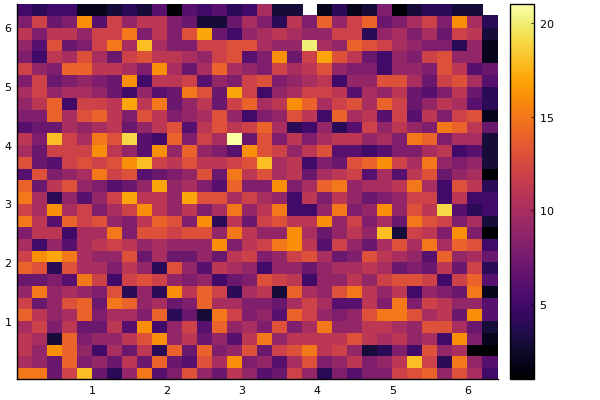

In [45]:
sample_size = 10000;
s = sampledist(sample_size, range);

histogram2d(s[:,1], s[:,2], bins=50)

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$. This map is defined in the function ```S``` which can then be iterated forward across timesteps via ```S_forward```.

We can then easily compare the initial density $f_0$ with a naive estimate of a limiting density $f_*$ by computing the latter with a big value for ```S_forward```.

In [46]:
fstar = S_forward(s, S, 100; map_type="standard");

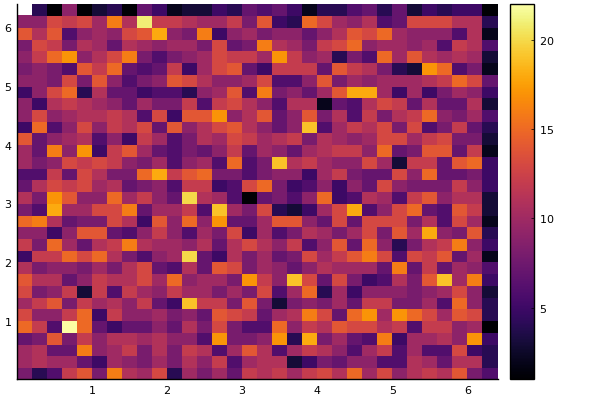

In [47]:
histogram2d(fstar[:,1], fstar[:,2], bins=50)

In this case, the limiting density is precisely the same constant function we started with, so we observe the same uniform distribution for `fstar`.

## Estimating the Perron-Frobenius operator
Having established a model for the dynamics, next we want to estimate the Perron-Frobenius operator,
$$
\mathcal{T} : L^1(X) \to L^1(X) .
$$
In particular, we are interested in this operator in the stochastic setting, which can be characterised by the presence of a transition kernel $k(\cdot, \cdot)$. This can be written as
$$
 \mathcal{T} f(y) = \int_X k(S(x), y ) f(x) \, \mathrm{d}x
$$
where $k(x, y) = \phi(x-y)$. 

To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $H$. Since $\mathcal{T}$ is linear, it will then suffice to compute its action on a basis. This will allow us to construct a square matrix $T$, which we will take to be our estimate of $\mathcal{T}$, in that $T(H) = \mathcal{T}(H)$.

### A finite basis
To compute $T$, we first must define a finite basis $H$ for $L^1(X)$. For the moment, we take this basis to be a uniform grid of $B$ Gaussian functions $\left\{ \varphi_i \right\}_{i=1}^B$ defined on the state space $X$. These will be of the form
$$
\varphi_i (x) = \phi ( x - z_i ) := \exp \left( - \frac{\| x - z_i \|^2}{\epsilon^2} \right)
$$
where the $z_i$ denote the centres of each RBF and $\epsilon$ is some bandwidth parameter. Each Gaussian function has integral $c = \int_X \varphi_i (x) \, \mathrm{d}x = \pi \epsilon^2$.

In [48]:
ϵ = 1.;
c = π * ϵ^2;

In [49]:
basis_grid_size = 5;
n_bases = basis_grid_size ^ 2;
basis_locs = creategrid(0, range, basis_grid_size);

These basis functions can be easily visualised by evaluating all grid points against each.

In [50]:
basis_evaluation_matrix = Array{Float64}(undef, n_gridpoints, n_bases);
for b in 1:n_bases
    for n in 1:n_gridpoints
        basis_evaluation_matrix[n, b] = φ(grid[n, :], basis_locs[b, :], ϵ);
    end
end

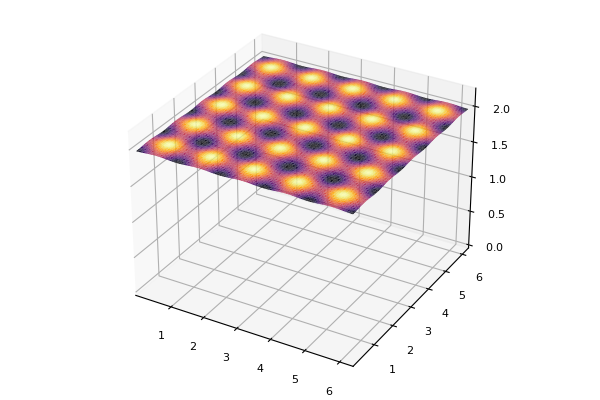

In [51]:
basis_surface = sum(basis_evaluation_matrix, dims=2)[:];
surface(grid[:,1], grid[:,2], basis_surface; legend=false)
zlims!(0,maximum(basis_surface)*1.1)

We get a nice, flat-looking basis surface, which can be used to approximate many functions in $L^1(X)$. To do so, we just take a linear combination of the basis functions. For example:

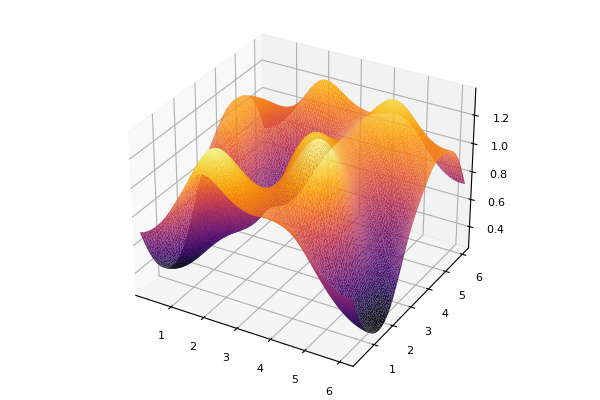

In [52]:
β = rand(n_bases)

test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

Of course, locally this basis surface is not quite so smooth...

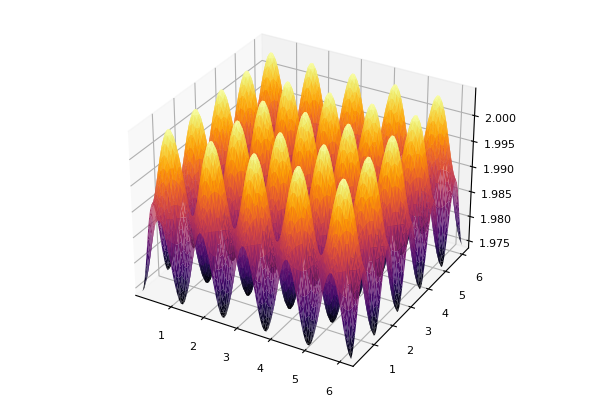

In [53]:
surface(grid[:,1], grid[:,2], basis_surface; legend=false)

...but all the values of the basis surface are nicely packed in a small interval, so this is fine.

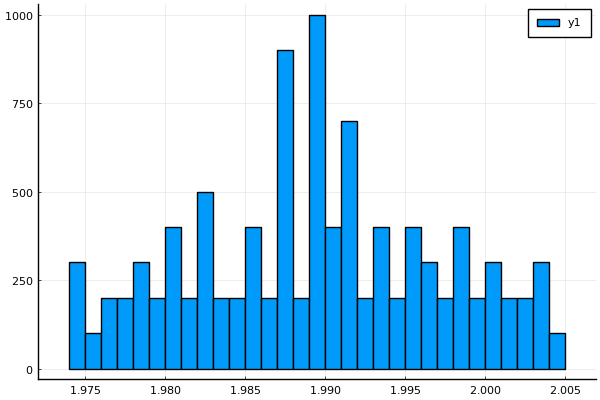

In [54]:
histogram(basis_surface)

### Numerical integration
In order to estimate the integral
$$
    \mathcal{L} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in H$ we will also need an approximate Lebesgue measure for the integral with respect to $\mathrm{d}x$. This will be some weighted combination of all the datapoints (since they are not uniformly spaced), subject to the constraint that obviously each basis function should integrate to $c = \pi\epsilon^2$. We can estimate these weights $w$ using nonnegative least squares,.

In [55]:
Φ = evaluate_phi(s, basis_locs, φ, ϵ);

In [56]:
C = c * ones(n_bases);
w_av = (range^2) / sample_size;

In [57]:
w, residual, objvalue = nnlsq_pen(Φ, C, w_av, 0.01);

Academic license - for non-commercial use only - expires 2021-08-05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 25 rows, 10025 columns and 250025 nonzeros
Model fingerprint: 0x4a8e7635
Model has 10025 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-09, 1e+00]
  Objective range  [8e-05, 8e-05]
  QObjective range [2e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+00]
Presolve time: 0.04s
Presolved: 25 rows, 10025 columns, 250025 nonzeros
Presolved model has 10025 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.000e+02
 Factor NZ  : 3.250e+02 (roughly 4 MBytes of memory)
 Factor Ops : 5.525e+03 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.60616844e+09 -1.

The weights should sum to close to $(2\pi)^2$, since this is the area of the state space.

In [58]:
println("Total sum of weights: $(sum(w))")
println("Area of state space: $((2π)^2)")
println("Ratio: $(sum(w) / (2π)^2)")

Total sum of weights: 39.479879130307175
Area of state space: 39.47841760435743
Ratio: 1.000037020884788


We would also expect that the average weight is close to an equal tesselation of the state space, since all the data points are uniformly distributed.

In [59]:
println("Average weight: $(mean(w))")
println("Equal tesselation size: $(w_av)")

Average weight: 0.003947987913030718
Equal tesselation size: 0.0039478417604357436


We might expect that since the sample points are uniformly distributed, the weights would be almost all equal. This is largely true.

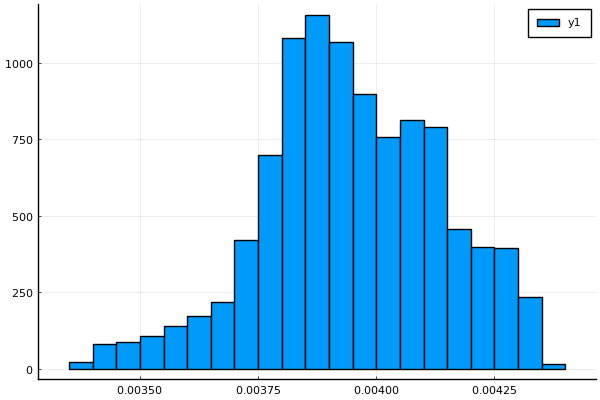

In [60]:
histogram(w)

With these weights, we can now compute the integral $\mathcal{T}f(x)$. In particular, we are interested in computing $\mathcal{T}\varphi_i(x)$ for all $B$ basis functions. Some straightforward arithmetic will show that
\begin{align*}
\mathcal{T}\varphi_i(y) &= \int_X k (Sx, y) \varphi_i(x) \, \mathrm{d}x \\
&= \int_X \phi (Sx - y) \varphi_i(x) \, \mathrm{d}x .
\end{align*}
For convenience, we will use the same stochastic kernel $\phi = \varphi$, where the $\varphi$ are now centered at the image points $S(x) = y$. So the above integral becomes the discrete sum
$$
\mathcal{T}\varphi_i(y) \approx \sum_{n=1}^N \left( w_n \cdot \varphi_i (x_n) \right) \varphi_{y_n} (y)
$$
Hence we can write each of the basis functions $\varphi_i$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{T} \varphi_i$ as just a linear combination of the $\varphi_i$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_n}$ itself as a linear combination of the $\varphi_i$.
$$
 \varphi_{y_n} (y) = \sum_{i=1}^B \gamma_i \varphi_i (y)
$$
Where do the weights $\gamma_i$ come from? we will need to calculate them according to the procedure that Gary has outlined. This says that
$$
\varphi_{y_n} (y) \approx Q \varphi_{y_n} (y) = \sum_{j=1}^B \left( \int_{V_j} c_j \varphi_{y_n} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$.

In [61]:
X = s;
Y = S(X; map_type="cat");

In [62]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

What about the weights $c_i$? Following Gary's procedure, these must satisfy
\begin{align*}
    \sum_{i=1}^B \langle \varphi_i , \mathbb{1} \rangle c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{i=1}^B C \cdot c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_i &= \frac{1}{C}
\end{align*}

This is now everything we need to compute the matrix $T$.

In [63]:
T = construct_T(w, Φ, Ξ, c);

In [64]:
display(T)

25×25 Matrix{Float64}:
 0.114939    0.0516516   0.00621024  …  0.0159115   0.0128116   0.042628
 0.041822    0.0468091   0.0161562      0.0455578   0.0422295   0.0128369
 0.0130139   0.0164975   0.0163158      0.0505201   0.117663    0.0505848
 0.0470921   0.00540828  0.00650006     0.0215351   0.123385    0.121802
 0.119792    0.022131    0.0018174      0.00531716  0.046765    0.111982
 0.0161867   0.0160573   0.0466335   …  0.11446     0.0475976   0.00536866
 0.0053356   0.00619557  0.0515616      0.118826    0.119436    0.0218695
 0.0210586   0.0017701   0.0220348      0.0473821   0.11843     0.0538672
 0.0506554   0.00611216  0.00558691     0.0129572   0.0454539   0.0484741
 0.0458355   0.0160488   0.0157997      0.0413191   0.0127896   0.0155034
 0.00177371  0.0217169   0.120258    …  0.115137    0.0521688   0.006263
 0.00611654  0.00542027  0.0479026      0.0427642   0.0462932   0.0157144
 0.0154873   0.0153812   0.0126721      0.0125129   0.0159977   0.0157938
 0.015389    0.045

## Checking the results
Now that we have an estimate of $L$, we can start appraising it.

### Plotting the spectrum
We expect that $L$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [65]:
λ, Λ = ordered_eigendecomp(T);

In [66]:
display(λ[1])

0.9999822306741337 + 0.0im

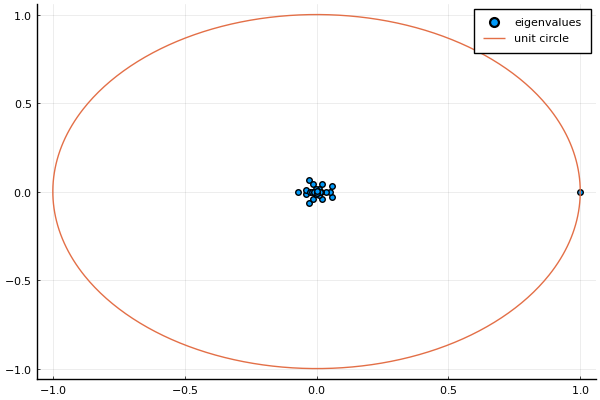

In [67]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")

Happily, this does indeed appear to be the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [68]:
sum(T, dims=2)

25×1 Matrix{Float64}:
 0.9999817196900845
 0.9999836073767899
 0.9999807502370563
 0.9999834544194842
 0.9999820755947866
 0.999981506124605
 0.9999811803544141
 0.9999843902844043
 0.9999815496841181
 0.9999831197143317
 0.9999821761139378
 0.9999815753658974
 0.9999827208769714
 0.9999833963030678
 0.9999813455462193
 0.9999816228282562
 0.9999826803263163
 0.9999820735915487
 0.9999809943186829
 0.9999832945334716
 0.9999828942646061
 0.9999820053742287
 0.9999831278470903
 0.9999816878697464
 0.9999808533136322

It indeed sums to the same number, which is of course the leading unit eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density.

In [69]:
α = real.(Λ[:,1]);

In [70]:
display(α)

25-element Vector{Float64}:
 0.19999984963561526
 0.20000027085504724
 0.1999997023904225
 0.20000020310450312
 0.19999990328952114
 0.1999998561313541
 0.1999997996191389
 0.2000004169064655
 0.199999824883417
 0.20000014514113393
 0.2000000121892366
 0.19999987774938185
 0.2000000921625531
 0.20000023429726918
 0.1999998431668918
 0.19999989884328628
 0.2000000975364859
 0.19999999097774712
 0.19999979907311574
 0.20000025586043613
 0.20000010699523682
 0.19999995175184826
 0.20000021772618584
 0.19999993019983037
 0.19999971951163878

In [71]:
invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);

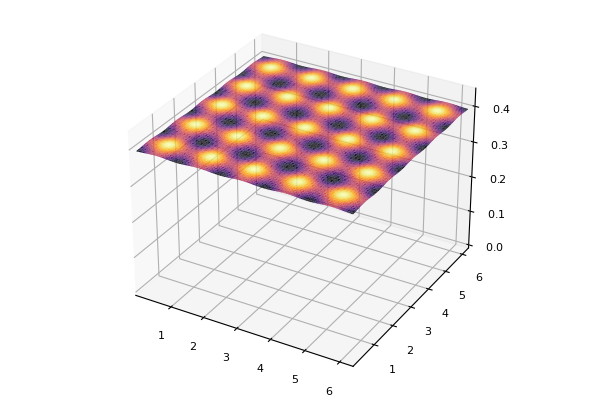

In [72]:
surface(grid[:,1], grid[:,2], invariant_density; legend=false)

if mean(invariant_density) > 0
    zlims!(0, maximum(invariant_density)*1.1)
else
    zlims!(minimum(invariant_density)*1.1, 0)
end

This looks pretty flat, which is good, since we know that the invariant density under the standard map is just the constant function.

### Evolving forward a density
Last, we try directly evolving forward a density using $T$. We start with a random function $f \in H$, where $f = \sum_{i=1}^B \beta_i \varphi_i$.

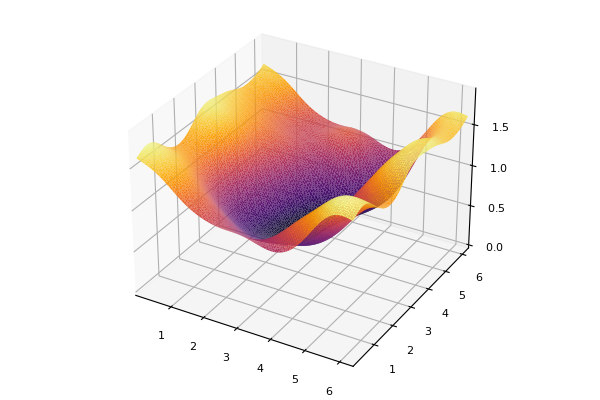

In [73]:
β = rand(n_bases)

initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], initial_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

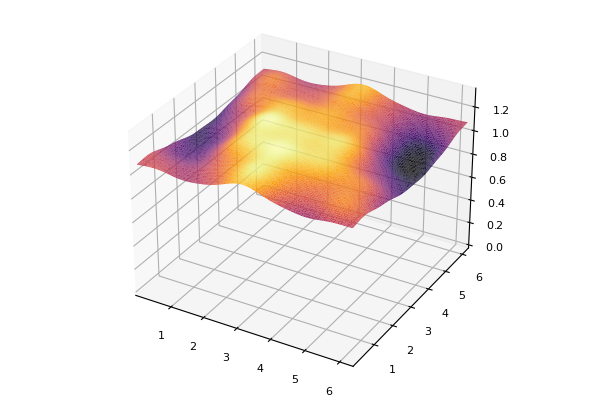

In [74]:
β1 = T * β;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β1);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

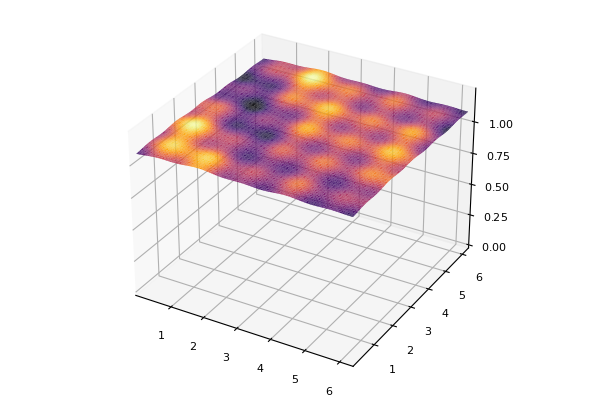

In [75]:
β2 = T * β1;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β2);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

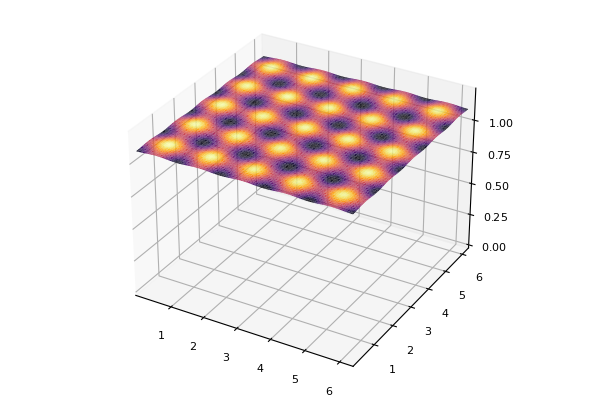

In [76]:
β3 = T * β2;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β3);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

After just three applications of $T$, we already see the limiting density clearly emerge.

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.